# Getting started

Ontology based atomic structure creation, manipulation, querying.

Imports

In [1]:
from pyscal_rdf import StructureGraph

First we create a graph

In [2]:
g = StructureGraph()

## Creation of structures

We will create three structures for the demonstration.

First a BCC Iron structure

In [3]:
struct_Fe = g.create.element.Fe()

Note that when the structure is created, it is also added to the Graph automatically. We can visualise the graph.

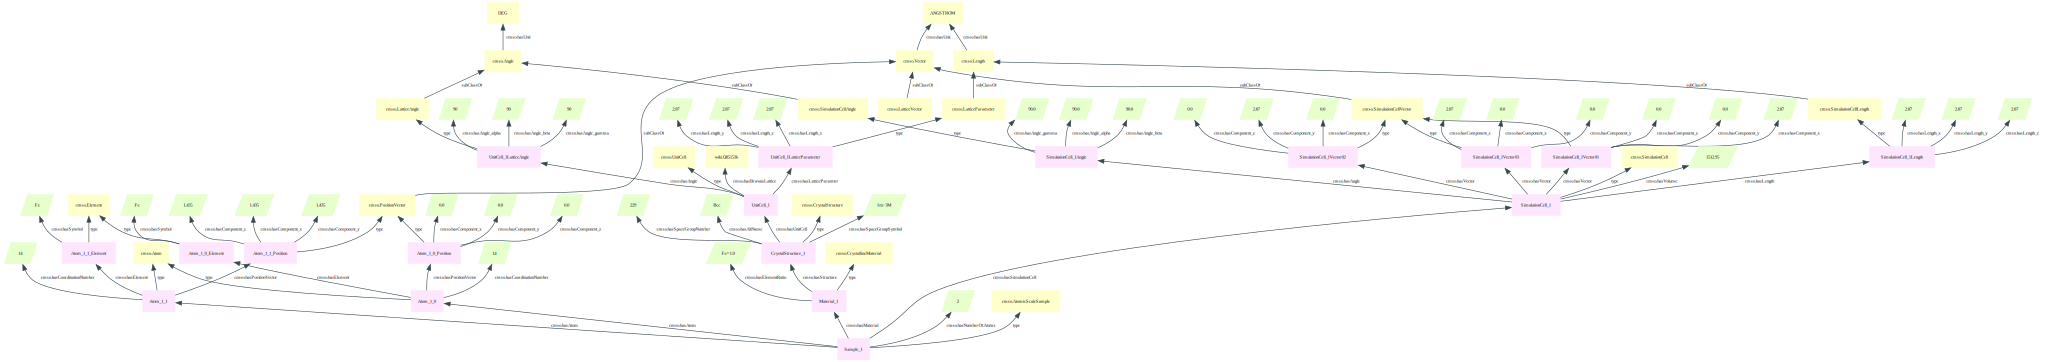

In [4]:
g.visualise(backend='graphviz')

Now a Si diamond structure

In [5]:
struct_Si = g.create.element.Si()

Finally, an L12 $Ni_3 Al$ structure

In [6]:
struct_l12 = g.create.lattice.l12(element=['Al', 'Ni'], 
                         lattice_constant=3.57)

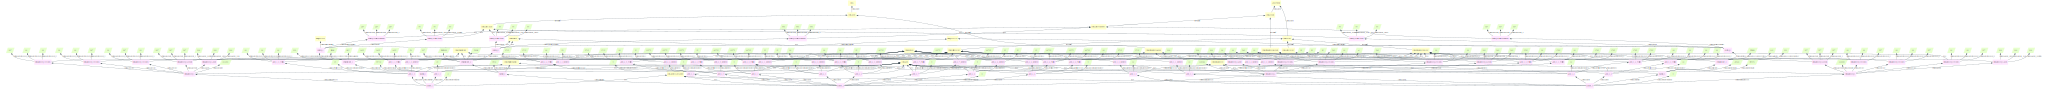

In [7]:
g.visualise(backend='graphviz')

We can save the graph and reload it as needed

## Querying the graph

An example question would be, **what are the space group of all structures with 4 atoms?**


The corresponding SPARQL query looks like this:

In [8]:
query = """
PREFIX cmso: <http://purls.helmholtz-metadaten.de/cmso/>
SELECT DISTINCT ?symbol
WHERE {
    ?sample cmso:hasNumberOfAtoms ?number .
    ?sample cmso:hasMaterial ?material .
    ?material cmso:hasStructure ?structure .
    ?structure cmso:hasSpaceGroupSymbol ?symbol .
FILTER (?number="4"^^xsd:integer)
}"""

In [9]:
res = g.query(query)

And print the results

In [10]:
res

,symbol
0,Pm-3m


The query system can also be used without experience in SPARQL, or deep knowledge about the ontology terms. For example, **What are all the samples with Bravais lattice bcc?**

First how this looks like:

In [13]:
res = g.auto_query(g.ontology.terms.cmso.ComputationalSample, g.ontology.terms.cmso.hasAltName, 
             condition=(g.ontology.terms.cmso.hasAltName=='bcc'))
res

,hasAltNamevalue,ComputationalSample
0,bcc,Sample_1


As expected, there is only one sample, since Fe is the only bcc structure we added. We can extract the sample

In [17]:
res.ComputationalSample[0]

rdflib.term.BNode('Sample_1')

We can write this sample to a file, for example, a LAMMPS data format, to use it for further simulations

In [15]:
g.to_file(samples[0], 'bcc.data', format="lammps-data")

In [16]:
! more bcc.data

bcc.data (written by ASE) 

2 	 atoms 
1  atom types
0.0      2.8700000000000001  xlo xhi
0.0      2.8700000000000001  ylo yhi
0.0      2.8700000000000001  zlo zhi


Atoms 

     1   1                       0                       0                      
 0
     2   1      1.4350000000000001      1.4350000000000001      1.43500000000000
01


We can also export as an ASE object

In [17]:
aseobj = g.to_file(samples[0], format="ase")

In [18]:
aseobj

Atoms(symbols='Fe2', pbc=True, cell=[2.87, 2.87, 2.87])

## Grain boundaries

Still under active development (early stages)..

We start by creating a $\Sigma 5 (3 \bar{1} 0)$

In [19]:
struct_gb_1 = g.create_grain_boundary(axis=[0,0,1], 
                        sigma=5, 
                        gb_plane=[3, -1, 0],
                        element='Fe')

Some other examples, $\Sigma 19 (\bar{3}20)$ and $\Sigma 19 (111)$

In [20]:
struct_gb_2 = g.create_grain_boundary(axis=[1,1,1], 
                        sigma=19, 
                        gb_plane=[-3, 2, 0],
                        element='Fe')

struct_gb_3 = g.create_grain_boundary(axis=[1,1,1], 
                        sigma=19, 
                        gb_plane=[-1, -1, -1],
                        element='Fe')

**What are all the samples with symmetric tilt grain boundaries?**

In [21]:
samples = q.sparql.sample_by_defect(g, "symmetric tilt")

In [22]:
samples

[rdflib.term.BNode('Sample_4')]

In [23]:
g.to_file(samples[0], filename="POSCAR", format="poscar")

In [24]:
! head -20 POSCAR

Fe 
 1.0000000000000000
    18.1514737599999982    0.0000000000000000    0.0000000000000000
     0.0000000000000000    2.8700000000000001    0.0000000000000000
     0.0000000000000000    0.0000000000000000    9.0757368799999991
 Fe 
  40
Cartesian
  0.9075736884683251  1.4350000000000001  7.2605895077465998
  0.0000000000000001  1.4350000000000001  4.5378684423416242
  2.7227210654049747  0.0000000000000000  8.1681631962149233
  3.6302947538732999  1.4350000000000001  6.3530158192782746
  1.8151473769366500  0.0000000000000000  5.4454421308099494
  2.7227210654049747  1.4350000000000001  3.6302947538732999
  0.9075736884683250  0.0000000000000000  2.7227210654049747
  1.8151473769366500  1.4350000000000001  0.9075736884683248
  0.0000000000000000  0.0000000000000000  0.0000000000000000
  7.2605895077465998  1.4350000000000001  8.1681631962149233
  5.4454421308099494  0.0000000000000000  7.2605895077465998
  6.3530158192782746  1.4350000000000001  5.4454421308099494


**What are all the samples with boundaries with sigma values between 7 and 21?**

In [25]:
samples = q.sparql.sample_by_sigma(g, [7, 21])

In [26]:
len(samples)

2